![Nuclio logo](https://nuclio.school/wp-content/uploads/2018/12/nucleoDS-newBlack.png)

## Primer ejemplo de Red Neuronal para el Master de Data Science de Nuclio School


Recordemos los pasos a seguiren la creación de código para entrenar una red neuronal:
<ol>
    <li>Importar librerias: Keras, PyPlot y Numpy (añado time y datetime para controlar los tiempos de entrenamiento)</li>
    <li>Definamos una red inicial (apilando bloques)</li>
    <li>Definimos (o creamos) nuestro optimizador, añadiendo nuestra función error</li>
    <li>Preparamos los datos (en este caso los cargamos)</li>
    <li>Empezamos con el entrenamiento</li>
    <li>Miramos los resultados y pasamos a la crítica mordaz</li>
</ol>

## 1. Librerias

Para empezar carguemos esas librerias que nos hacen falta

In [1]:
from tensorflow import keras as ks
from matplotlib import pyplot as plt
import numpy as np
import time
import datetime

## 2. Arquitectura de red del modelo

Construimos un modelo sencillo de red neuronal para los datos MNIST, que en resumen son:
- Datos de entrada: imagenes de 28x28 pixeles con un canal de grises (valores de 1 a 256, enteros)
- Datos de salida (labels): a cada imagen le otorgamos un valor de 0 a 9, un total de 10 classes

<img src="https://3qeqpr26caki16dnhd19sv6by6v-wpengine.netdna-ssl.com/wp-content/uploads/2016/05/Examples-from-the-MNIST-dataset.png">

Para montar la arquitectura de la red neuronal se sigue el método **.Sequential()** de Keras (de input a output):

- **Entrada** - Una conversion de una matriz 2D de 28x28 pixeles a un vector - método Flatten
- **Oculto** - Una capa densa (fully connected) con 16 neuronas y activación lineal
- **Salida** - Una capa densa (fully connected) con 10 neuronas (**las 10 clases de salida**) y activación lineal

<img alt="" src="//upload.wikimedia.org/wikipedia/commons/thumb/1/11/Colored_neural_network_es.svg/300px-Colored_neural_network_es.svg.png" decoding="async" width="300" height="361" class="thumbimage" srcset="//upload.wikimedia.org/wikipedia/commons/thumb/1/11/Colored_neural_network_es.svg/450px-Colored_neural_network_es.svg.png 1.5x, //upload.wikimedia.org/wikipedia/commons/thumb/1/11/Colored_neural_network_es.svg/600px-Colored_neural_network_es.svg.png 2x" data-file-width="296" data-file-height="356">

In [2]:
model = ks.Sequential()   # modelo tipo secuencial

model.add(ks.layers.Conv2D(16, (3,3), strides=1, activation='relu', kernel_initializer='he_uniform', input_shape=(28,28,1))) # No mejoramos el modelo metiendo mas convoluciones para buscar texturas. deberemos mejorar la clasificacion
model.add(ks.layers.Conv2D(16, (3,3), strides=1, activation='relu', kernel_initializer='he_uniform')) # duplicamos las convoluciones, empezamos con VGG 
model.add(ks.layers.MaxPool2D(pool_size=(2,2)))      # reducimos los tamaños de las imagenes a la mitad
model.add(ks.layers.Dropout(0.6))                    # dropout siempre despues del maxpool --> pack 2 convo, 1 maxpool, 1 dropout lo ponemos de 0.2 a 0.6 para ver si mejora el overfitting

model.add(ks.layers.Flatten())                       # convierto las fotos de 28,28, matrices de 2d, a una en array lineal 1 dimension
model.add(ks.layers.Dense(128, activation='relu'))   # capa profunda de 16 neuronas, la puedo modificar a 32 64 128 256 1024 --> ponemos 128 para mejorar la fase de clasificacion
model.add(ks.layers.Dropout(0.3))                    # intento mejorar el overfitting   

model.add(ks.layers.Dense(128, activation='relu'))   # capa profunda de 16 neuronas, la puedo modificar a 32 64 128 256 1024 --> ponemos 128 para mejorar la fase de clasificacion
model.add(ks.layers.Dropout(0.3))                    # intento mejorar el overfittin

model.add(ks.layers.Dense(10, activation='softmax')) # esta capa es la de salida, no la puedo modificar, tengo 10 clases, necesito 10 neuronas
model.summary()

# este ejercicio no necesita batch normalization porque tiene solo 6 capas, no hay peligro de explosion de valores
# aumentar de convoluciones de 16 a 32 no nos ha mejorado el accuracy
# la red tiene que ser mas compleja cuanto mas complejos sean los datos
# este modelo no necesita mas convoluciones sino mejorar la clasificacion, metemos una capa dense y una capa dropout
# Activation 'linear' es para regresiones. Para clasificacion necesitamos la 'relu' o la 'softmax'
# En la salida de clasificacion, si es 1 clase entonces 'sigmoid', si es multiclase entonces 'softmax'

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 16)        160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 16)        2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 2304)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               295040    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0

Para revisar un modelo, nos basta con llamar al método **.summary()** del modelo

tDel **.summary()** se extrae información muy relevante: el número de paràmetros por capa y el total a entrenar.4

Fijaos que 28x28 son 784 valores, así que es lo que tenemos de entrada. Esos 784 neuronas se enlazan con 16 (16 * 784 pesos + 16 bias = 12560) y
 esas 16 con las 10 de salida (16 * 10 pesos + 10 bias). Un total de 12730 parametros que aprender  

## 3. Optimizador, función error

Definimos los parametros del modelo para su entrenamiento:
* **Loss** - Función de error (función de coste) - Optamos por la Sparse Categorical Crosstentropy porque estamos clasificando imagenes
* **Optimizer** - que optimizador de la función de coste usaremos, en este ejemplo SGD (Stochastic gradient descent)
* **Metrics** - que metrica usaremos para evaluar el modelo... en este caso se usa la Accuracy

**Nota sobre SGD:** por defecto lleva un learning rate de 0.01 y sin momentum (valor de 0.0)

In [3]:
model.compile(optimizer='Adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'] )

## 4. Preparamos los datos

Cargamos los datos de MNIST de los datasets directamente de las librerias de Keras. Estos ya estan dispuestos en train and test

**Detalle importante:** 
> La red neuronal requiere que los inputs sean números reales, y lo haremos forzando la division de los valores de dentro de las matrices 28x28 (que tienen valoress del 0 al 255) por 255.0 (un real)

In [4]:
mnist = ks.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train, x_test = x_train / 255.0, x_test / 255.0                # dividimos por 255.0 para tener los valores entre 0 y 1, valores REALES

11493376/11490434 [==============================] - 0s 0us/step


Pintemos una muestra de las imagenes del dataset MNIST, a ver si se parece en algo a lo que esperamos.
Primero, vemos que tipos de datos tengo, después mapeamos esas matrices en una escala de grises utilizando el método **.get_cmap()** de PlotLy con los nueve primeros números del dataset.

Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)


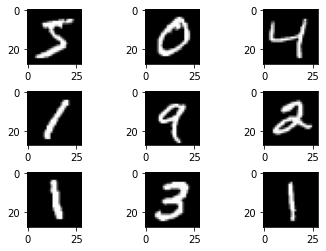

In [5]:
# IMPORTANTE, imprimiros de vez en cuando los SHAPES de los arrays que utilizamos


print('Train: X=%s, y=%s' % (x_train.shape, y_train.shape))
print('Test: X=%s, y=%s' % (x_test.shape, y_test.shape))

for i in range(9):
    plt.subplot(330 + 1 + i)
    plt.imshow(x_train[i], cmap=plt.get_cmap('gray'))

plt.subplots_adjust(hspace = 0.5)
plt.show()

Como vamos a querer ir haciendo validación a la vez que entrenamos (muy practico)

In [6]:
x_val = x_train[-10000:]   # agafo a partir del 10.000 fins el final
y_val = y_train[-10000:]   # agafo a partir del 10.000 fins el final

x_train = x_train[:-10000]  # agafo desde 0 fins a 10.000
y_train = y_train[:-10000]  # agafo desde 0 fins a 10.000



In [7]:
print('Train: X=%s, y=%s' % (x_train.shape, y_train.shape))
print('Validation: X=%s, y=%s' % (x_val.shape, y_val.shape))
print('Test: X=%s, y=%s' % (x_test.shape, y_test.shape))

Train: X=(50000, 28, 28), y=(50000,)
Validation: X=(10000, 28, 28), y=(10000,)
Test: X=(10000, 28, 28), y=(10000,)


In [8]:
x_train_cnn = x_train.reshape((50000, 28, 28, 1))
x_test_cnn = x_test.reshape((10000, 28, 28, 1))
x_val_cnn = x_val.reshape((10000, 28, 28, 1))

## 5. Entrenamiento

Ya podemos ponernos a entrenar el modelo!!

Empezaremos con 30 epocs, es decir, 30 pasadas completas del dataset (que a su vez sera con mini-batches internamente), por defecto en Keras, **el batch_size es de 32**.

El metodo .fit() nos permite, definir además si disponemos de varias CPUs, GPUs, y si queremos ir validando datos a cada fin de epoch.

**Nota: Este fit, en mi laptop no tarda más de 2 minutos.** (por eso vale la pena capturar los tiempos, así podeis validar las capacidades de vuestro equipo y valorar Google Colab).

In [9]:
t = time.perf_counter()

In [10]:
history = model.fit(x_train_cnn, y_train, epochs=100, batch_size=512, # incrementamos el batch size para que vaya mas rapido por defecto 32, 50000/512= 98
                    use_multiprocessing=False, validation_data=(x_val_cnn, y_val))

Epoch 1/100
98/98 [==============================] - 8s 14ms/step - loss: 1.4247 - accuracy: 0.5190 - val_loss: 0.1555 - val_accuracy: 0.9564
Epoch 2/100
98/98 [==============================] - 1s 9ms/step - loss: 0.2938 - accuracy: 0.9116 - val_loss: 0.0930 - val_accuracy: 0.9739
Epoch 3/100
98/98 [==============================] - 1s 9ms/step - loss: 0.1967 - accuracy: 0.9404 - val_loss: 0.0724 - val_accuracy: 0.9809
Epoch 4/100
98/98 [==============================] - 1s 9ms/step - loss: 0.1639 - accuracy: 0.9517 - val_loss: 0.0621 - val_accuracy: 0.9829
Epoch 5/100
98/98 [==============================] - 1s 9ms/step - loss: 0.1355 - accuracy: 0.9588 - val_loss: 0.0544 - val_accuracy: 0.9844
Epoch 6/100
98/98 [==============================] - 1s 9ms/step - loss: 0.1166 - accuracy: 0.9662 - val_loss: 0.0482 - val_accuracy: 0.9861
Epoch 7/100
98/98 [==============================] - 1s 9ms/step - loss: 0.1082 - accuracy: 0.9667 - val_loss: 0.0452 - val_accuracy: 0.9870
Epoch 8/100


#### 50000 imagenes / 32 imagenes cada vez (backsize por defecto) = 1562.5 es lo que utiliza cada epoch.   
#### Accuracy 0.10 acierta 1 imagen de cada 10

In [11]:
elapsed_time = datetime.timedelta(seconds=(time.perf_counter() - t))

print('Tiempo de entrenamiento:', elapsed_time)

Tiempo de entrenamiento: 0:01:38.506592


## 6. Evaluamos los resultados

Obtengamos una grafica de como el error y la accuracy van evolucionando en cada epoch en los datos de entrenamiento y en la validación

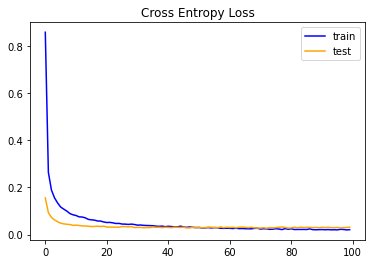

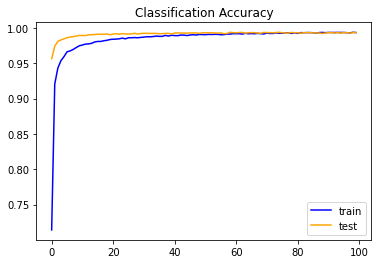

In [12]:
plt.title('Cross Entropy Loss')
plt.plot(history.history['loss'], color='blue', label='train')
plt.plot(history.history['val_loss'], color='orange', label='test')
plt.legend()
plt.show()

plt.title('Classification Accuracy')
plt.plot(history.history['accuracy'], color='blue', label='train')
plt.plot(history.history['val_accuracy'], color='orange', label='test')
plt.legend()
plt.show()

Evaluemos el modelo contra los valores de testeo

In [13]:
model.evaluate(x_test_cnn,  y_test, verbose=2)

313/313 - 0s - loss: 0.0239 - accuracy: 0.9935


[0.023906579241156578, 0.9934999942779541]

El coste podemos ver que es estable. Además la accuracy baila muchísimo. No se puede decir que sea un modelo muy bueno.

Veamos que tipo de predicciones estoy obteniendo sobre el conjunto de test (vamos a pintar las imagenes y sus clasificaciones)

In [14]:
predictions = model.predict(x_test_cnn)

Una de las ventajas de Python es que hay montones de funciones y código realizado por terceras personas. Aquí me he fusilado unas bonitas funciones (que he adaptado un poco a mis necesidades) para poder pintar las imagenes, su label (ground truth) y las clasificaciones que hemos realizado.

In [15]:
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array, true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(predicted_label,
                                100*np.max(predictions_array),
                                true_label),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array, true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

Dibujamos los primeros digitos, con las predicciones y sus valores reales (un total de 20 imagenes, para no abusar de vuestros laptops)

Coloreamos las prediciones correctas en azul y los fallos en rojo

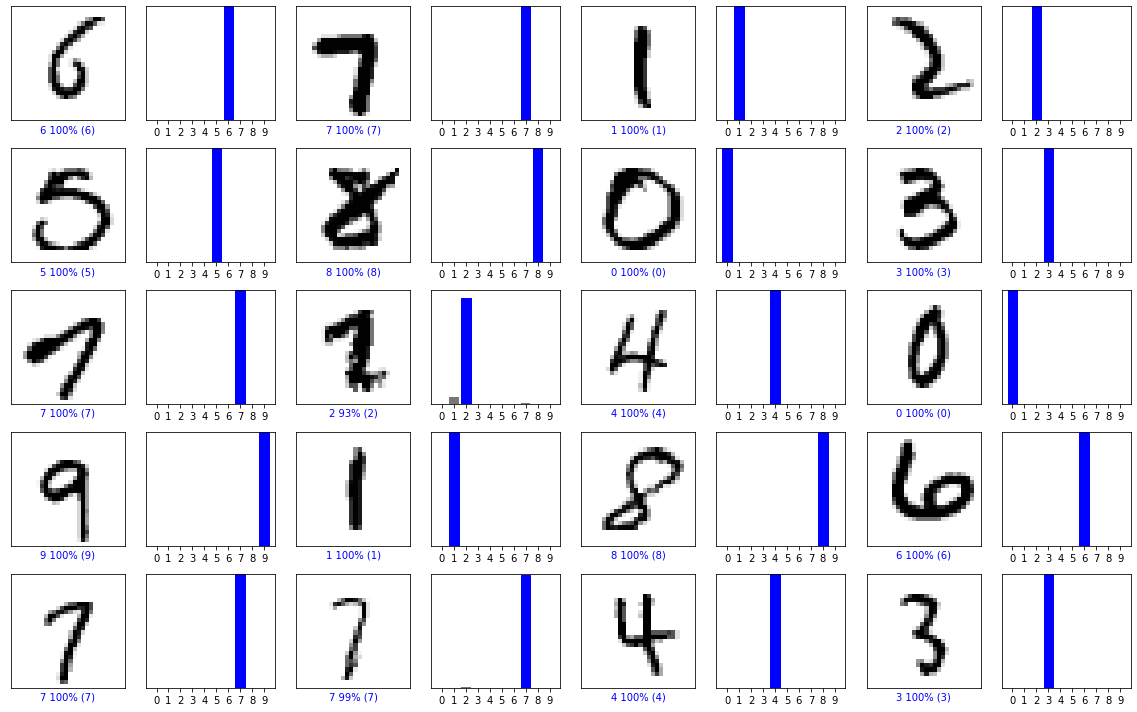

In [16]:
num_rows = 5
num_cols = 4
start = 650
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i+start, predictions[i+start], y_test, x_test)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i+start, predictions[i+start], y_test)
plt.tight_layout()
plt.show()

In [17]:
from tensorflow.keras.models import load_model

model.save('mnist_model.h5')